<a href="https://colab.research.google.com/github/letianzj/QuantResearch/blob/master/workbooks/option_pricer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [20]:
import copy
from enum import Enum
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.stats import norm
from typing import Iterable, List

In [21]:
pd.options.display.float_format = '{:,.5f}'.format

https://github.com/robertmartin8/pValuation

In [14]:
class OptionType(Enum):
  CALL = 1
  PUT = 2

class EquityOption:

  def __init__(
      self,
      S: float,
      K: float,
      vol: float = 0.16,
      dte: int = 365,
      r: float = 0.0,
      q: float = 0.0,
      typ: OptionType = OptionType.CALL,
      mult: float = 100.0,
  ) -> None:

    self.S = S
    self.K = K
    self.vol = vol
    self.dte = dte
    self.r = r
    self.q = q
    self.typ = typ
    self.mult = mult

  @property
  def T(self) -> float:
    return self.dte / 365.0

  @property
  def d1(self) -> float:
    d1 = (np.log(self.S / self.K) + (self.r - self.q + 0.5 * self.vol ** 2) * self.T) / (self.vol * np.sqrt(self.T))
    return d1

  @property
  def d2(self) -> float:
    d2 = (np.log(self.S / self.K) + (self.r - self.q - 0.5 * self.vol ** 2) * self.T) / (self.vol * np.sqrt(self.T))
    return d2

  @property
  def price(self) -> float:
    result = 0.0
    if self.typ == OptionType.CALL:
        result = (self.S * np.exp(-self.q * self.T) * norm.cdf(self.d1, 0.0, 1.0) - self.K * np.exp(-self.r * self.T) * norm.cdf(self.d2, 0.0, 1.0))
    elif self.typ == OptionType.PUT:
        result = (self.K * np.exp(-self.r * self.T) * norm.cdf(-self.d2, 0.0, 1.0) - self.S * np.exp(-self.q * self.T) * norm.cdf(-self.d1, 0.0, 1.0))

    return result

  @property
  def delta(self) -> float:
    result = 0.0
    if self.typ == OptionType.CALL:
        result = np.exp(-self.q * self.T) * norm.cdf(self.d1, 0.0, 1.0)
    elif self.typ == OptionType.PUT:
        result = - np.exp(-self.q * self.T) * norm.cdf(-self.d1, 0.0, 1.0)

    return result

  @property
  def gamma(self) -> float:
    # result = K * np.exp(-r*T) * np.pdf(d2) / S / S / vol / np.sqrt(T)
    return np.exp(-self.q*self.T) * norm.pdf(self.d1) / self.S / self.vol / np.sqrt(self.T)

  @property
  def vega(self) -> float:
    # result2 = K * np.exp(-r * T) *  norm.pdf(d2, 0.0, 1.0) * np.sqrt(T)
    # assert result == result2, 'vega failed'
    return self.S * np.exp(-self.q * self.T) * norm.pdf(self.d1, 0.0, 1.0) * np.sqrt(self.T)

  @property
  def theta(self) -> float:
    result = 0.0
    if self.typ == OptionType.CALL:
        result = - np.exp(-self.q * self.T) * self.S * norm.pdf(self.d1, 0.0, 1.0) * self.vol / 2 / np.sqrt(self.T) \
                 - self.r * self.K * np.exp(-self.r * self.T) * norm.cdf(self.d2, 0.0, 1.0) \
                 + self.q * self.S * np.exp(-self.q * self.T) * norm.cdf(self.d1, 0.0, 1.0)
    elif self.typ == OptionType.PUT:
        result = - np.exp(-self.q * self.T) * self.S * norm.pdf(-self.d1, 0.0, 1.0) * self.vol / 2 / np.sqrt(self.T) \
                 + self.r * self.K * np.exp(-self.r * self.T) * norm.cdf(-self.d2, 0.0, 1.0) \
                 - self.q * self.S * np.exp(-self.q * self.T) * norm.cdf(-self.d1, 0.0, 1.0)
    return result

  @property
  def rho(self) -> float:
    result = 0.0
    if self.typ == OptionType.CALL:
        result = self.K * self.T * np.exp(-self.r*self.T) * norm.cdf(self.d2, 0.0, 1.0)
    elif self.typ == OptionType.PUT:
        result = -self.K * self.T * np.exp(-self.r*self.T) * norm.cdf(-self.d2, 0.0, 1.0)

    return result

  @property
  def vanna(self) -> float:
    """d^2V/dS/dvol; vega rt spot or delta rt vol"""
    return -np.exp(-self.q*self.T) * norm.pdf(self.d1) * self.d2 / self.vol

  @property
  def volga(self) -> float:
    """d^2V/dvol^2, vega rt vol"""
    return self.S*np.exp(-self.q*self.T) * norm.pdf(self.d1) * np.sqrt(self.T) * self.d1 * self.d2 / self.vol

  @property
  def charm(self) -> float:
    """delta time decay"""
    result = -np.exp(-self.q * self.T) * norm.pdf(self.d1) * (2 * (self.r - self.q) * self.T - self.d2 * self.vol * np.sqrt(self.T)) / 2 / self.T / self.vol / np.sqrt(self.T)
    if self.typ == OptionType.CALL:
        result += self.q * np.exp(-self.q * self.T) * norm.cdf(self.d1)
    elif self.typ == OptionType.PUT:
        result -= self.q * np.exp(-self.q * self.T) * norm.cdf(-self.d1)
    return result

  @property
  def color(self) -> float:
    """gamma time decay"""
    return -np.exp(-self.q * self.T) * norm.pdf(self.d1) / 2 / self.S / self.T / self.vol / np.sqrt(self.T) * (2 * self.q * self.T + 1 + (2 * (self.r - self.q) * self.T - self.d2 * self.vol * np.sqrt(self.T)) / self.vol / np.sqrt(self.T) * self.d1)

  @property
  def zomma(self) -> float:
    """gamma rt vol"""
    return np.exp(-self.q * self.T) * norm.pdf(self.d1) * (self.d1 * self.d2 - 1) / self.S  / self.vol / self.vol / np.sqrt(self.T)

  @property
  def veta(self) -> float:
    """vega time decay"""
    return -self.S * np.exp(-self.q * self.T) * norm.pdf(self.d1) * np.sqrt(self.T) * (self.q + (self.r - self.q) * self.d1 / self.vol / np.sqrt(self.T) - (1+self.d1*self.d2)/2/self.T)

  def summary(self) -> pd.DataFrame:
    df = (
          pd.DataFrame.from_dict({
          'd1': self.d1,
          'd2': self.d2,
          'price': self.price,
          'delta': self.delta,
          'gamma': self.gamma,
          'vega': self.vega,
          'theta': self.theta,
          'rho': self.rho,
          'vanna': self.vanna,
          'volga': self.volga,
          'charm': self.charm,
          'color': self.color,
          'zomma': self.zomma,
          'veta': self.veta,
      }, orient='index')
      .set_axis(['BS'], axis=1)
    )
    df['Market'] = df['BS']
    df.loc['price', 'Market'] = df.loc['price', 'BS'] * self.mult
    df.loc['delta', 'Market'] = df.loc['delta', 'BS'] * self.mult
    df.loc['gamma', 'Market'] = df.loc['gamma', 'BS'] * self.mult
    df.loc['vega', 'Market'] = df.loc['vega', 'BS'] / 100.0 * self.mult   # Vega is sigma moves 1 or 100%. So 1% is 4.4422; then multiplied by multiplier (cancel out)
    df.loc['theta', 'Market'] = df.loc['theta', 'BS'] / 365.0 * self.mult # Theta is 1yr or 365d. So divide by 365 then multiplied by multiplier
    df.loc['rho', 'Market'] = df.loc['rho', 'BS'] / 100.0 * self.mult     # Rho is rate moves 1 or 100%, then multiplied by multiplier (cancel out)
    # vanna is vega change from vega to vega + vanna when S changes one dollar; or delta changes from delta + vanna/100 when vol changes 1% from vol to vol + 1%
    df.loc['vanna', 'Market'] = df.loc['vanna', 'BS'] / 100.0 * self.mult
    # volga is vega changes from vega to vega + volga / 100 when vol changes 1% from vol to vol + 1%
    df.loc['volga', 'Market'] = df.loc['volga', 'BS'] / 100.0 * self.mult
    # charm or delta decay, equals delta changes from delta to delta - charm / 365 when time decays one day
    df.loc['charm', 'Market'] = df.loc['charm', 'BS'] / 365.0 * self.mult
    # color is gamma time decay, equals gamma changes from gamma to color / 365 when time decays one day ?
    df.loc['color', 'Market'] = df.loc['color', 'BS'] / 365.0 * self.mult
    # zomma is gamma rt vol, equals gamma changes from gamma to gamma + zomma/100 when vol moves 1% ?
    df.loc['zomma', 'Market'] = df.loc['zomma', 'BS'] / 100.0 * self.mult
    # veta is vega time decays, equals vega changes from vega to vega / 365 when time decays one day ?
    df.loc['veta', 'Market'] = df.loc['veta', 'BS'] / 365.0 / 100.0 * self.mult

    df.index.name = 'Call' if self.typ == OptionType.CALL else 'Put'
    return df

  def implied_vol(self, target_price: float, update_vol: bool=False) -> float:
    MAX_ITERATIONS = 500
    PRECISION = 1.0e-8
    vol_copy = self.vol
    self.vol = 0.50
    for i in range(MAX_ITERATIONS):
      price = self.price
      vega = self.vega
      diff = target_price - price
      if (abs(diff) < PRECISION):
        break
      self.vol += diff/self.vega   # f(x) / f'(x)
    ret = self.vol
    if not update_vol:
      self.vol = vol_copy
    return ret

o1 = EquityOption(S=4436, K=4455, r = 0.05, q=0.00, vol=0.156, dte=23, typ=OptionType.CALL)
o1.summary()

,BS,Market
Call,,
d1,-0.00911,-0.00911
d2,-0.04827,-0.04827
price,66.87181,"6,687.18098"
delta,0.49637,49.63676
gamma,0.00230,0.22965
vega,444.22305,444.22305
theta,-656.62163,-179.89634
rho,134.53519,134.53519
vanna,0.12342,0.12342


In [16]:
print(o1.implied_vol(80.0, update_vol=True))
print(o1.price)

0.18555235412748686
80.00000000408772


In [111]:
class OptionPortfolio:

  def __init__(
      self,
      options: List[EquityOption],
      weights: List[float],
  ) -> None:

    assert len(options) == len(weights), 'options and weights have to match in length'
    self.options = copy.deepcopy(options)
    self.weights = weights
    self._COLUMNS = ['price', 'delta', 'gamma', 'vega', 'theta', 'rho', 'vanna', 'volga', 'charm', 'color', 'zomma', 'veta']

  def summary(self) -> pd.DataFrame:
    df_bs = (
        pd.concat([op.summary()['BS'] * self.weights[idx] for idx, op in enumerate(self.options)], axis=1)
        .sum(axis=1)
        [self._COLUMNS]
    )
    df_market = (
        pd.concat([op.summary()['Market'] * self.weights[idx] for idx, op in enumerate(self.options)], axis=1)
        .sum(axis=1)
        [self._COLUMNS]
    )
    df = (
        pd.concat([df_bs, df_market], axis=1)
        .set_axis(['BS', 'Market'], axis=1)
    )
    return df

  def span(
      self,
      x_variable: str,
      y_variable: str,
      control_variable: str,
      x_span: Iterable,
      control_span: Iterable,
  ) -> None:

    self.x_variable = x_variable
    self.y_variable = y_variable
    self.control_variable = control_variable
    self.x_span = x_span
    self.control_span = control_span

    options_bak = copy.deepcopy(self.options)
    control_list = []
    for c in control_span:
      single_line_dict = dict()
      for x in x_span:
        for o in self.options:
          o.__dict__[self.control_variable] = c
          o.__dict__[self.x_variable] = x
        single_line_dict[x] = self.summary().loc[y_variable, 'BS']
      single_line_ser = pd.Series(single_line_dict)
      single_line_ser.name = c
      control_list.append(single_line_ser)
    df = pd.concat(control_list, axis=1)
    self.options = options_bak
    return df

o1 = EquityOption(S=4300, K=4455, r = 0.05, q=0.00, vol=0.1, dte=23, typ=OptionType.CALL)
o2 = EquityOption(S=4300, K=4500, r = 0.05, q=0.00, vol=0.1, dte=23, typ=OptionType.CALL)

op = OptionPortfolio(options=[o1, o2], weights=[1, -1])
op.span(
    x_variable='S',
    y_variable='price',
    control_variable='vol',
    x_span=np.arange(4000, 4600, 100),
    control_span=[0.1, 0.15, 0.2]
)

,0.10000,0.15000,0.20000
4000,0.00030,0.07817,0.61611
4100,0.01665,0.52397,1.94174
4200,0.34851,2.31541,4.86683
4300,3.06522,7.04875,9.94231
4400,12.62500,15.49747,16.97717
4500,27.90190,25.94074,24.87951


<Axes: >

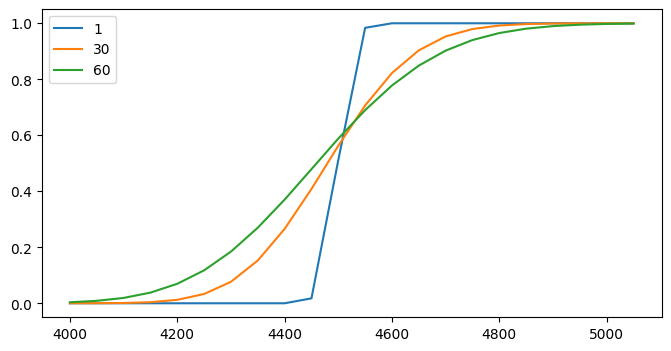

In [148]:
o = EquityOption(S=4500, K=4500, r = 0.05, q=0.00, vol=0.1, dte=23, typ=OptionType.CALL)
op = OptionPortfolio(options=[o], weights=[1])

op.span(
    x_variable='S',
    y_variable='delta',
    control_variable='dte',
    x_span=np.arange(4000, 5100, 50),
    control_span=[1, 30, 60]
).plot(figsize=(8, 4))

<Axes: >

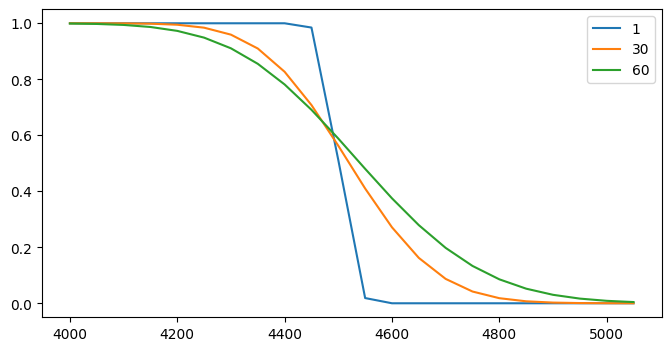

In [149]:
o = EquityOption(S=4500, K=4500, r = 0.05, q=0.00, vol=0.1, dte=23, typ=OptionType.CALL)
op = OptionPortfolio(options=[o], weights=[1])

# veta
op.span(
    x_variable='K',
    y_variable='delta',
    control_variable='dte',
    x_span=np.arange(4000, 5100, 50),
    control_span=[1, 30, 60]
).plot(figsize=(8, 4))

<Axes: >

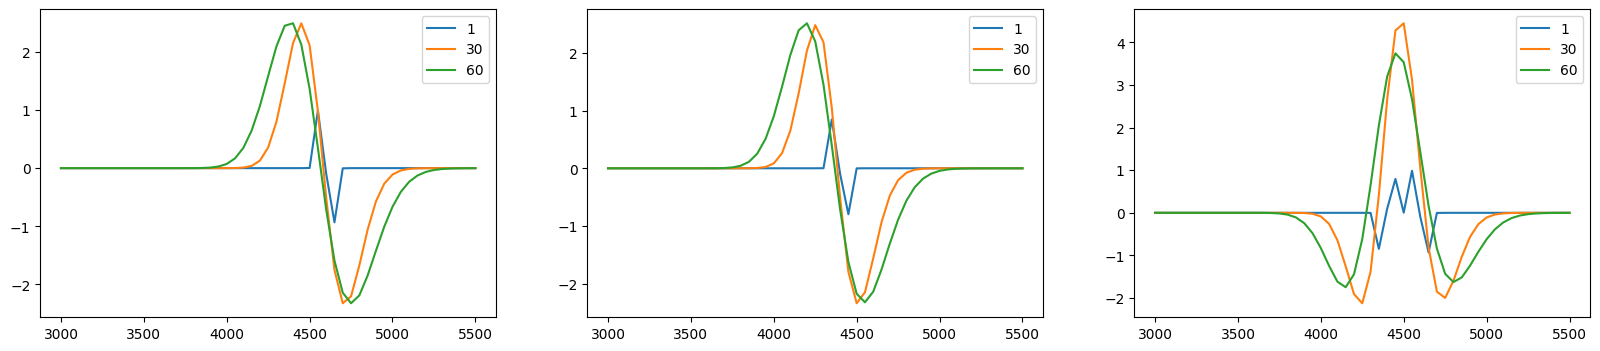

In [166]:
o1 = EquityOption(S=4500, K=4600, r = 0.05, q=0.00, vol=0.1, dte=23, typ=OptionType.CALL)
o2 = EquityOption(S=4500, K=4400, r = 0.05, q=0.00, vol=0.1, dte=23, typ=OptionType.PUT)
rr = OptionPortfolio(options=[o1, o2], weights=[1, -1])

fig, ax = plt.subplots(1, 3, figsize=(20, 4))
OptionPortfolio(options=[o1], weights=[1]).span(
    x_variable='S',
    y_variable='vanna',
    control_variable='dte',
    x_span=np.arange(3000, 5550, 50),
    control_span=[1, 30, 60]
).plot(ax=ax[0])
OptionPortfolio(options=[o2], weights=[1]).span(
    x_variable='S',
    y_variable='vanna',
    control_variable='dte',
    x_span=np.arange(3000, 5550, 50),
    control_span=[1, 30, 60]
).plot(ax=ax[1])
rr.span(
    x_variable='S',
    y_variable='vanna',
    control_variable='dte',
    x_span=np.arange(3000, 5550, 50),
    control_span=[1, 30, 60]
).plot(ax=ax[2])

<Axes: >

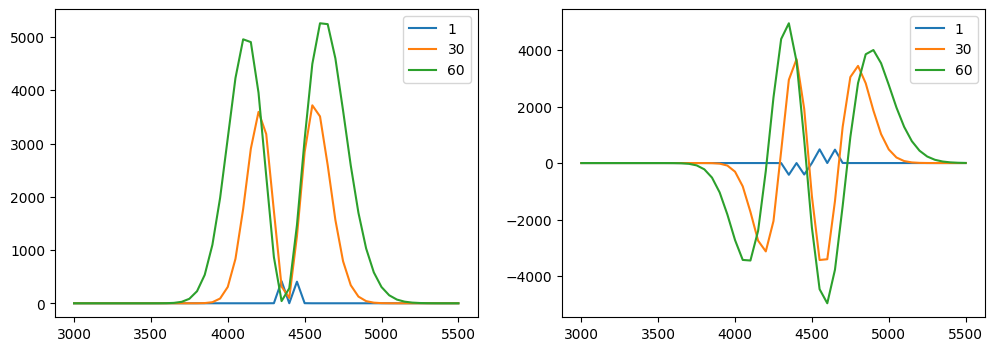

In [170]:
o1 = EquityOption(S=4500, K=4400, r = 0.05, q=0.00, vol=0.1, dte=23, typ=OptionType.CALL)
o2 = EquityOption(S=4500, K=4500, r = 0.05, q=0.00, vol=0.1, dte=23, typ=OptionType.CALL)
o3 = EquityOption(S=4500, K=4600, r = 0.05, q=0.00, vol=0.1, dte=23, typ=OptionType.CALL)
bf = OptionPortfolio(options=[o1, o2, o3], weights=[1, -2, 1])

fig, ax = plt.subplots(1, 2, figsize=(12, 4))
OptionPortfolio(options=[o1], weights=[1]).span(
    x_variable='S',
    y_variable='volga',
    control_variable='dte',
    x_span=np.arange(3000, 5550, 50),
    control_span=[1, 30, 60]
).plot(ax=ax[0])
rr.span(
    x_variable='S',
    y_variable='volga',
    control_variable='dte',
    x_span=np.arange(3000, 5550, 50),
    control_span=[1, 30, 60]
).plot(ax=ax[1])

In [124]:
class FuturesOption:

  def __init__(
      self,
      F: float,
      K: float,
      vol: float = 0.16,
      dte: int = 365,
      r: float = 0.,
      typ: OptionType = OptionType.CALL,
      mult: float = 100.0,
  ) -> None:

    self.F = F
    self.K = K
    self.vol = vol
    self.dte = dte
    self.r = r
    self.typ = typ
    self.mult = mult

  @property
  def T(self) -> float:
    return self.dte / 365.0

  @property
  def d1(self) -> float:
    d1 = (np.log(self.F / self.K) + (0.5 * self.vol ** 2) * self.T) / (self.vol * np.sqrt(self.T))
    return d1

  @property
  def d2(self) -> float:
    d2 = (np.log(self.F / self.K) - (0.5 * self.vol ** 2) * self.T) / (self.vol * np.sqrt(self.T))
    return d2

  @property
  def price(self) -> float:
    result = 0.0
    if self.typ == OptionType.CALL:
        result = np.exp(-self.r*self.T)*( self.F*norm.cdf(self.d1) - self.K*norm.cdf(self.d2) )
    elif self.typ == OptionType.PUT:
        result = np.exp(-self.r*self.T)*( self.K*norm.cdf(-self.d2) - self.F*norm.cdf(-self.d1) )

    return result

  @property
  def delta(self) -> float:
    result = 0.0
    if self.typ == OptionType.CALL:
        result = np.exp(-self.r*self.T)*norm.cdf(self.d1)
    elif self.typ == OptionType.PUT:
        result = -np.exp(-self.r*self.T)*norm.cdf(-self.d1)

    return result

  @property
  def gamma(self) -> float:
    # result = k*np.exp(-r*T)*norm.pdf(d2)/F/F/vol/np.sqrt(T)
    return np.exp(-self.r*self.T)*norm.pdf(self.d1)/self.F/self.vol/np.sqrt(self.T)

  @property
  def vega(self) -> float:
    # result = K * np.exp(-r*T) * norm.pdf(d2)*np.sqrt(T)
    return self.F * np.exp(-self.r * self.T) * norm.pdf(self.d1) * np.sqrt(self.T)

  @property
  def theta(self) -> float:
    result = 0.0
    if self.typ == OptionType.CALL:
        result = -self.F*np.exp(-self.r*self.T)*norm.pdf(self.d1)*self.vol/2/np.sqrt(self.T) \
                 - self.r*self.K*np.exp(-self.r*self.T)*norm.cdf(self.d2) \
                 + self.r*self.F*np.exp(-self.r*self.T)*norm.cdf(self.d1)
    elif self.typ == OptionType.PUT:
        result = -self.F * np.exp(-self.r * self.T) * norm.pdf(-self.d1) * self.vol / 2 / np.sqrt(self.T) \
                 + self.r * self.K * np.exp(-self.r * self.T) * norm.cdf(-self.d2) \
                 - self.r * self.F * np.exp(-self.r * self.T) * norm.cdf(-self.d1)
    return result

  @property
  def rho(self) -> float:
    result = 0.0
    if self.typ == OptionType.CALL:
        result = self.K*self.T*np.exp(-self.r*self.T)*norm.cdf(self.d2)
    elif self.typ == OptionType.PUT:
        result = -self.K*self.T*np.exp(-self.r*self.T)*norm.cdf(-self.d2)
    return result

  @property
  def vanna(self) -> float:
    """d^2V/dS/dvol; vega rt spot or delta rt vol"""
    return -np.exp(-self.r*self.T)*norm.pdf(self.d1)*self.d2/self.vol

  @property
  def volga(self) -> float:
    """d^2V/dvol^2, vega rt vol"""
    return self.F*np.exp(-self.r*self.T)*norm.pdf(self.d1)*np.sqrt(self.T)*self.d1*self.d2/self.vol

o2 = FuturesOption(F=100, K=100)
o2.price, o2.delta, o2.gamma, o2.vega, o2.theta, o2.rho, o2.vanna, o2.volga

(6.376274402797485,
 0.5318813720139874,
 0.024854231594475557,
 39.76677055116089,
 -3.1813416440928712,
 46.81186279860126,
 0.19883385275580445,
 -1.5906708220464356)

# Data

In [1]:
import yfinance as yf

In [2]:
spy = yf.Ticker("SPY")

In [4]:
spy.history(period="1mo").head()

,Open,High,Low,Close,Volume,Dividends,Stock Splits,Capital Gains
Date,,,,,,,,
2023-07-26 00:00:00-04:00,454.470001,456.989990,453.380005,455.510010,71052900,0.0,0.0,0.0
2023-07-27 00:00:00-04:00,459.019989,459.440002,451.549988,452.489990,92194400,0.0,0.0,0.0
2023-07-28 00:00:00-04:00,455.880005,457.779999,452.489990,456.920013,80011800,0.0,0.0,0.0
2023-07-31 00:00:00-04:00,457.410004,458.160004,456.049988,457.790009,62040400,0.0,0.0,0.0
2023-08-01 00:00:00-04:00,456.269989,457.250000,455.489990,456.480011,55291500,0.0,0.0,0.0


In [7]:
spy.options

('2023-08-28',
 '2023-08-29',
 '2023-08-30',
 '2023-08-31',
 '2023-09-01',
 '2023-09-05',
 '2023-09-06',
 '2023-09-07',
 '2023-09-08',
 '2023-09-15',
 '2023-09-22',
 '2023-09-29',
 '2023-10-06',
 '2023-10-20',
 '2023-11-17',
 '2023-12-15',
 '2023-12-29',
 '2024-01-19',
 '2024-03-15',
 '2024-03-28',
 '2024-06-21',
 '2024-06-28',
 '2024-09-20',
 '2024-12-20',
 '2025-01-17',
 '2025-03-21',
 '2025-06-20',
 '2025-12-19')

In [17]:
calls = spy.option_chain('2023-08-28').calls

In [18]:
calls

,contractSymbol,lastTradeDate,strike,lastPrice,bid,ask,change,percentChange,volume,openInterest,impliedVolatility,inTheMoney,contractSize,currency
0,SPY230828C00350000,2023-08-23 15:10:49+00:00,350.0,92.06,89.80,90.64,0.000000,0.000000,10.0,10,1.183598,True,REGULAR,USD
1,SPY230828C00360000,2023-08-24 13:42:01+00:00,360.0,83.81,79.81,80.65,0.000000,0.000000,1.0,17,1.062505,True,REGULAR,USD
2,SPY230828C00370000,2023-08-25 16:25:55+00:00,370.0,68.67,69.55,70.38,-5.150002,-6.976432,15.0,11,1.006841,True,REGULAR,USD
3,SPY230828C00371000,2023-08-24 13:42:01+00:00,371.0,72.82,68.55,69.65,0.000000,0.000000,1.0,8,0.835939,True,REGULAR,USD
4,SPY230828C00372000,2023-08-24 14:20:16+00:00,372.0,71.24,67.83,68.65,0.000000,0.000000,1.0,10,0.916016,True,REGULAR,USD
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
107,SPY230828C00478000,2023-08-24 14:01:13+00:00,478.0,0.01,0.00,0.01,0.000000,0.000000,1.0,1,0.328132,False,REGULAR,USD
108,SPY230828C00479000,2023-08-21 14:03:01+00:00,479.0,0.01,0.00,0.01,0.000000,0.000000,20.0,20,0.335944,False,REGULAR,USD
109,SPY230828C00480000,2023-08-24 14:46:01+00:00,480.0,0.01,0.00,0.01,0.000000,0.000000,1.0,49,0.339850,False,REGULAR,USD
110,SPY230828C00505000,2023-08-18 19:50:12+00:00,505.0,0.01,0.00,0.01,0.000000,0.000000,1988.0,1988,0.515630,False,REGULAR,USD


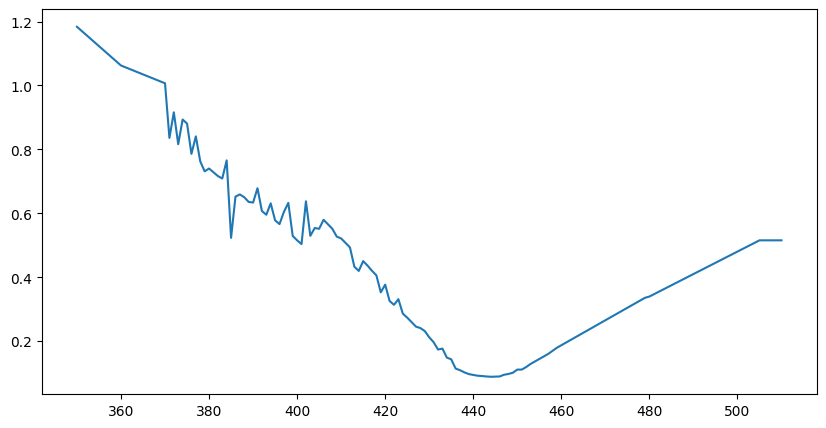

In [25]:
plt.figure(figsize=(10,5))
plt.plot(calls['strike'], calls['impliedVolatility'])